In [19]:
def off_diagonal_vec(sop):
    new_mat = []
    for i, row in enumerate(sop):
        for j, col in enumerate(row):
            if i==j:
                continue
            new_mat.append(col)
    return np.array(new_mat)

In [30]:
def sop_to_ptm(sop):
    ret = np.zeros((4,4))
    for i, p in enumerate(ps):
        for j, q in enumerate(ps):
            ret[i][j] = np.trace(p.dot(sop.dot(q.dot(np.conj(sop.T)))))
    return ret

In [42]:
from scipy.linalg import expm
import numpy as np
from pauli_channel_approximation import off_diagonal_projection

scales = [1.064, 1.039, .937, .912]
x = np.array([[0, 1], [1, 0]])
unitaries = []
ps = [np.eye(2), x, np.array([[0, -1.j], [1.j, 0]]), np.array([[1, 0], [0, -1]])]
pps = [np.kron(p, q) for p in ps for q in ps]
vecs = []
for scale in scales:
    unitary = expm(-1.j * scale * np.pi/2 * x)
    error =  np.conj(unitary.T).dot(x)
    vecs.append(off_diagonal_vec(sop_to_ptm(error)))

/home/apolloreno/anaconda3/envs/estuary/lib/python3.7/site-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


In [53]:
omega = cp.Variable(4)
constraints = [0 <= omega, omega <= 1, sum(omega) == 1]
objective_argument = cp.norm(np.matrix(np.vstack(vecs).T) * omega)
objective = cp.Minimize(objective_argument)
prob = cp.Problem(objective, constraints)
_ = prob.solve(solver=cp.MOSEK, verbose=True)
res = omega.value

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 22              
  Cones                  : 1               
  Scalar variables       : 18              
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 22              
  Cones               

In [54]:
res

matrix([[0.3071617 ],
        [0.28249117],
        [0.21143395],
        [0.19891318]])

In [15]:
from pauli_channel_approximation import *

/home/apolloreno/anaconda3/envs/estuary/lib/python3.7/site-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


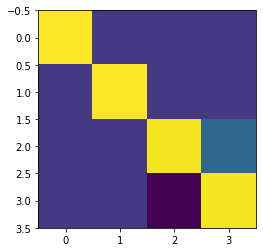

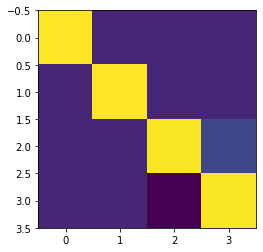

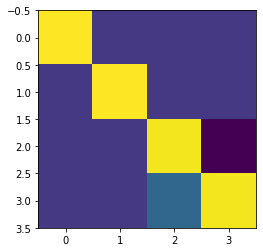

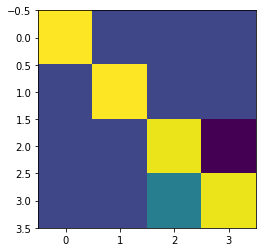

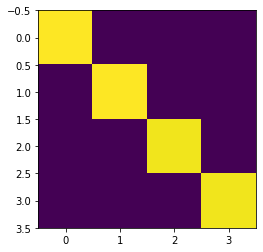

In [80]:
%matplotlib inline
import matplotlib.pyplot as plt
sops = []
for scale in scales:
    unitary = expm(-1.j * scale * np.pi/2 * x)
    error =  np.conj(unitary.T).dot(x)
    plt.imshow(sop_to_ptm(error))
    plt.show()
    sops.append(error)
avg = np.zeros((4,4))
for i, sop in enumerate(sops):
    avg += res[i].tolist()[0][0] * sop_to_ptm(sop)
plt.imshow(avg)

In [ ]:
def off_diagonal_projection(sop):
    """
    Computes a quantity proportional to the sum of the magnitudes of terms corresponding to non-stochastic evolution.

    :param numpy.ndarry sop: Representation our operator as a superoperator, e.g. operating on vectorized density
     matrices.
    """
    basis = PAULIS
    for _ in range(int(np.log2(sop.shape[0]) / 2.0) - 1):
        basis = [np.kron(base, pauli) for pauli in PAULIS for base in basis]
    off_diagonal = 0
    for i, base1 in enumerate(basis):
        for j, base2 in enumerate(basis):
            if i != j:
                off_diagonal += np.abs(np.trace(adjoint(np.kron(base1, base2)).dot(sop))) ** 2
    return off_diagonal
